In [7]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [8]:
# read data
df = pd.read_csv("data/npf_train.csv")

In [9]:
df.head()

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-02-23,nonevent,False,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,...,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686
1,2,2000-03-25,Ib,False,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,...,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
2,3,2000-04-06,Ib,False,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,...,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072
3,4,2000-04-11,nonevent,False,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,...,1.753414,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209
4,5,2000-04-23,II,False,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,...,10.940107,2.179821,11.441893,3.048699,13.087014,9.771415,0.525591,0.476821,0.003680,0.002160


In [10]:
# create new class that is either event or nonevent
df["class2"] = ["nonevent" if x=="nonevent" else "event" for x in df["class4"]]

In [11]:
# set date as index and drop definitely useless columns (id, partlybad, class4)
del df["date"]
del df["id"]
del df["partlybad"]
del df["class4"]
df.head()

,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,...,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,class2
0,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,380.296466,0.968884,236.605353,145.160571,...,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686,nonevent
1,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,138.921953,...,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210,event
2,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,372.193952,0.596289,269.981547,200.826676,...,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072,event
3,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,381.381156,7.208287,68.364653,48.560722,...,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209,nonevent
4,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,375.337059,2.903780,242.192619,190.952026,...,2.179821,11.441893,3.048699,13.087014,9.771415,0.525591,0.476821,0.003680,0.002160,event


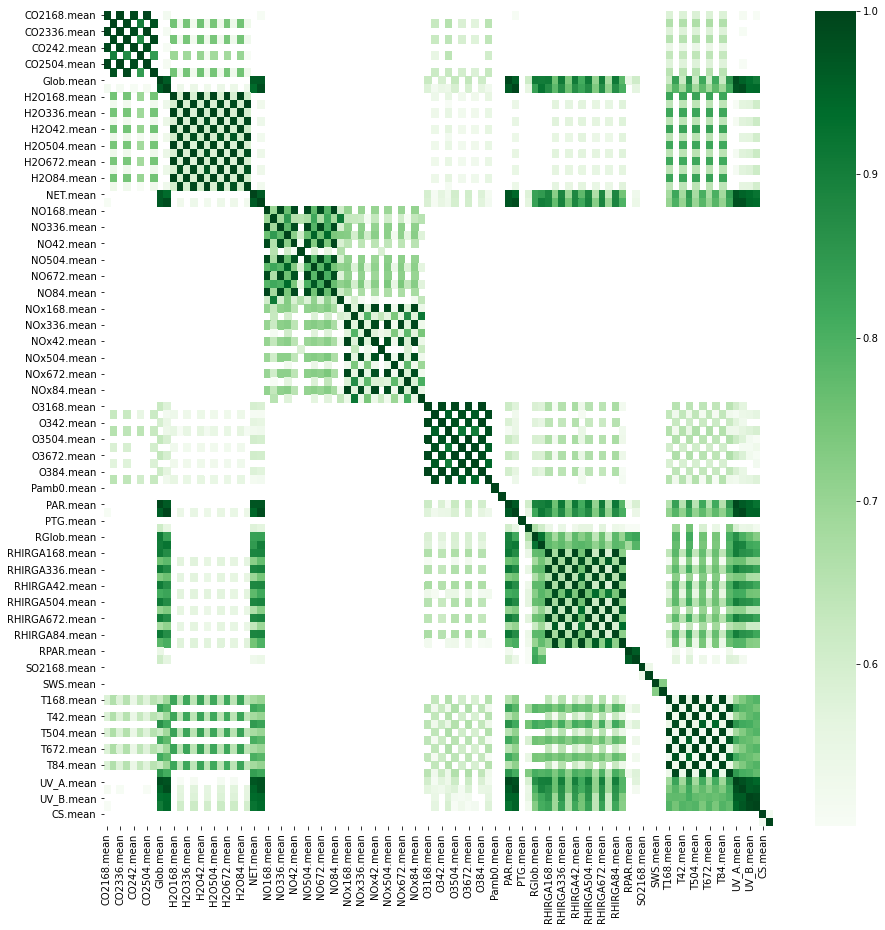

In [12]:
# correlation matrix
plt.figure(figsize=(15,15))
corr = df.corr().abs()
corr = corr[corr>=0.5] #treshold
sns.heatmap(corr, cmap = "Greens")
plt.show()

In [13]:
# select X and y variables
X = df.loc[:, df.columns != 'class2']
y = df["class2"]
y = [1 if v=="event" else 0 for v in y]

# Feature selection
## By hand

In [14]:
def hand(X):
    # indexes to be deleted
    delidx=[]
    # loop column names
    for i,col in enumerate(X.columns):
        # Drop all .std - columns 
        if col[-4:]==".std":
            delidx.append(i)

        # Drop different altitude columns
        if col[:3]=="CO2" and col!="CO2168.mean":
            delidx.append(i)
        if col[:3]=="H20" and col != "H20168.mean":
            delidx.append(i)        
        if col[:2] == "NO" and col != "NO168.mean" and col[:3] != "NOx":
            delidx.append(i)        
        if col[:3] == "NOx" and col != "NOx168.mean":
            delidx.append(i)
        if col[:2] == "O3" and col != "O3168.mean":
            delidx.append(i)
        if col[:6] == "RHIRGA" and col != "RHIRHGA168.mean":
            delidx.append(i)
        if col[:1] == "T" and col != "T168.mean":
            delidx.append(i)
    X = X.drop(X.columns[delidx], axis=1)

    assert(len(X.columns) == 23)
    
    return X

## Recursive feature elimination

In [15]:
from sklearn.feature_selection import RFECV

def rfe(X):
    # define a model
    model = RandomForestClassifier()
    # 20cross validation, eliminate one feature per iteration
    selector = RFECV(model, step=1, cv=20) 
    # Fit to the data
    selector = selector.fit(X, y)
    # Apply dimension reduction to X
    return selector.transform(X)

## PCA feature selection

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca(X):
    # standarsize the data - PCA is affected by scale
    scaler = StandardScaler()
    # fit on training only
    scaler.fit(X)
    X = scaler.transform(X)

    # Feature selection using PCA
    # n_components='mle': Minka’s MLE(used to guess the dimension)
    pca = PCA(n_components='mle', svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
    # fit only on training data
    pca.fit(X)
    # Apply dimensionality reduction to X
    X = pca.transform(X)
    #print("Number of features: {}".format(len(pca.components_)))
    return X

# Model selection

In [17]:
# KFold cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

def modeling(model, X):
    cv = KFold(n_splits=20, shuffle=True)
    model = model

    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [18]:
# accuracies of the models using hand selected features, pca features and rfe features(takes a while).
name = ["hand", "pca", "rfe"]
selection = [hand(X), pca(X), rfe(X)]

for i in range(len(name)):
    print('\n')
    print("feature selection: {}".format(name[i]))
    x = selection[i]
    modeling(LogisticRegression(),x)
    modeling(SVC(),x)
    modeling(RandomForestClassifier(),x)
    modeling(ExtraTreesClassifier(),x)
    modeling(DecisionTreeClassifier(),x)




feature selection: hand
Accuracy: 0.830 (0.080)
Accuracy: 0.767 (0.094)
Accuracy: 0.870 (0.042)
Accuracy: 0.879 (0.069)
Accuracy: 0.830 (0.067)


feature selection: pca
Accuracy: 0.893 (0.056)
Accuracy: 0.877 (0.055)
Accuracy: 0.853 (0.076)
Accuracy: 0.859 (0.057)
Accuracy: 0.737 (0.096)


feature selection: rfe
Accuracy: 0.875 (0.071)
Accuracy: 0.774 (0.089)
Accuracy: 0.879 (0.063)
Accuracy: 0.883 (0.078)
Accuracy: 0.805 (0.082)


# Final model

In [172]:
model = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=1.0, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=None, 
                           solver='lbfgs', 
                           max_iter=100, 
                           multi_class='auto', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=None, 
                           l1_ratio=None)


modeling(model,pca(X))

Accuracy: 0.902 (0.059)


# TPOT for fun

In [133]:
X_train, X_test, y_train, y_test = train_test_split(hand(X), y, train_size=0.75, test_size=0.25)

In [134]:
# TPOT
from tpot import TPOTClassifier
import timeit

tpot = TPOTClassifier(verbosity=2, 
                      scoring="balanced_accuracy", 
                      random_state=123, 
                      periodic_checkpoint_folder="tpot1", 
                      n_jobs=-1, 
                      generations=3,
                      cv=20,
                      population_size=100)


tpot.fit(X_train, np.array(y_train))
tpot.export('tpot_pipeline.py')



Generation 1 - Current best internal CV score: 0.888343253968254

Generation 2 - Current best internal CV score: 0.888343253968254

Generation 3 - Current best internal CV score: 0.888343253968254

Best pipeline: ExtraTreesClassifier(GaussianNB(input_matrix), bootstrap=False, criterion=gini, max_features=0.7000000000000001, min_samples_leaf=3, min_samples_split=2, n_estimators=100)
